# Testing

This notebook is to test that a transmon behaves as expected when it is driven.

## replaced fixed detuning with variable detuning

In [1]:
# imports
import numpy as np
from qutip import basis
import matplotlib.pyplot as plt
from transmon_code.transmon import *
from transmon_code.simulate import *
from transmon_code.helpers import *
from transmon_code.shapes import H1_coeffs

In [2]:
# define the transmon

tr = Transmon(n_levels=8, initial_state=0, Ω=2*np.pi*3981, α=2*np.pi*-199, dt=1/50000)

# for a pulse of length 0.024
tr.X90_args = {'A': 1.031448621300667, 'τ': 0.024, 'λ': -0.9741688740061742, 'α': tr.α, 'ω': tr.Ω, 'δ': -18.680342034571783}

tr.X90_args = {'A': 1.031448621300667, 'τ': 0.024, 'λ': 1, 'α': tr.α, 'ω': tr.Ω, 'δ': 0}

tr.X90_args = {'A': 0.9821623327698041, 'τ': 0.024, 'λ': 0, 'α': tr.α, 'ω': tr.Ω, 'δ':-5.070445236848315}

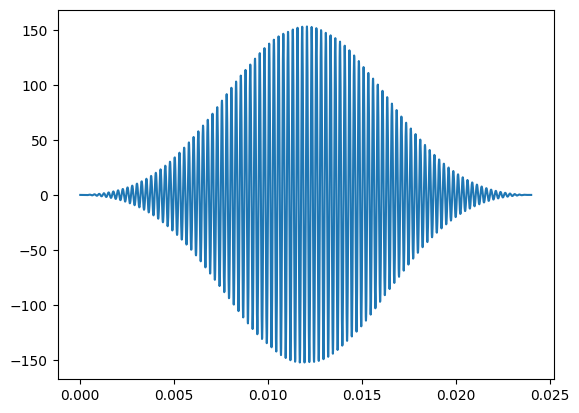

Fidelity (f):                0.9987866429951627
Measured error (1-f):        0.0012133570048372677

Leakage error:               0.0012132996220172703
Theoretical coherence error: 0.0
Error accounted for:         0.0012132996220172703

Error unaccounted for:       5.7382819997411905e-08


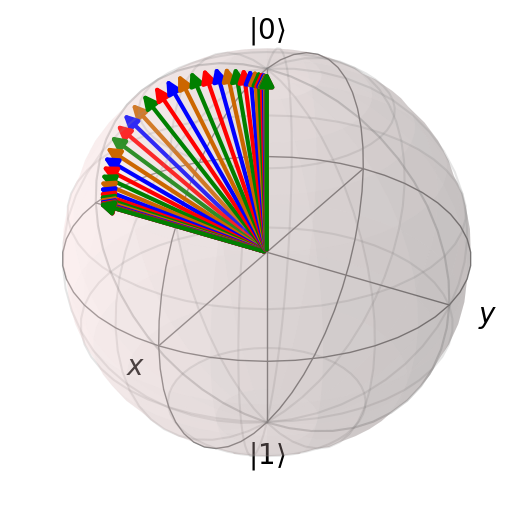

In [3]:
# test an X90 pulse from 0 to - (minus)

tr.ψ0 = (basis(8,0)+0*basis(8,1)).unit()

targ = (basis(tr.n_levels, 0)-1j*basis(tr.n_levels, 1)).unit()

res, f = simulate(tr, tr.X90_args, target=targ, noise=False, plot=True)

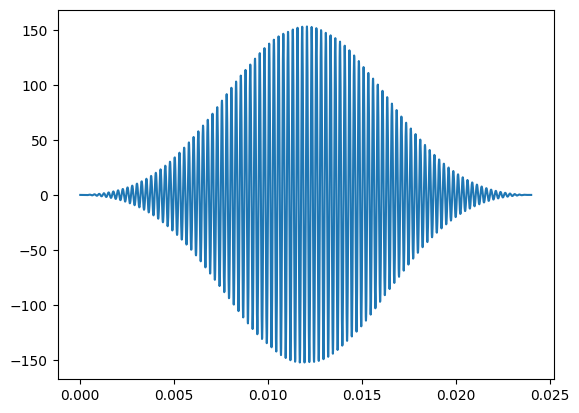

Fidelity (f):                0.9958400995018556
Measured error (1-f):        0.004159900498144409

Leakage error:               0.0018609363490860258
Theoretical coherence error: 0.0
Error accounted for:         0.0018609363490860258

Error unaccounted for:       0.002298964149058383


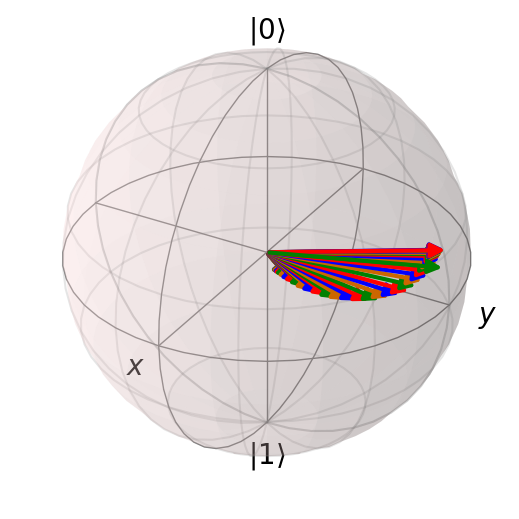

In [4]:
# test an X90 pulse on a random initial state

tr.ψ0 = expand(rand_ket(2), tr.n_levels).unit()
targ = expand(calculate_target_state([U(gate_angles["X90"])], truncate(tr.ψ0), plot=False), tr.n_levels).unit()

res, f = simulate(tr, tr.X90_args, target=targ, noise=False, plot=True)

tr.ψ0 = basis(tr.n_levels, 0)

Fidelity (f):                0.9817210622667113
Measured error (1-f):        0.018278937733288703

Leakage error:               0.004553856462377041
Theoretical coherence error: 0.0
Error accounted for:         0.004553856462377041

Error unaccounted for:       0.013725081270911661


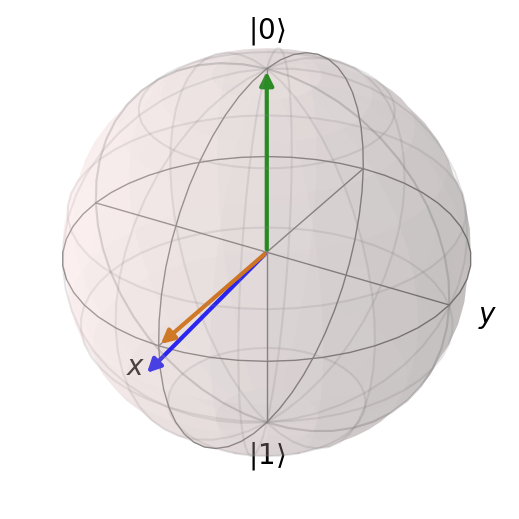

In [5]:
# test a noisy circuit by simulating each pulse individually

# define which two gates are to be tested
gate1 = "X90"
gate2 = "Z90"

# setup transmon and target
target = calculate_target_state([gate1, gate2], tr.ψ0)
target = expand(target, tr.n_levels)
tr.ψ0 = basis(tr.n_levels, 0)

# prep for plotting
b = Bloch()
b.make_sphere()
b.add_states(truncate(tr.ψ0))
b.add_states(truncate(target))

# gate 1
θ, φ, λ = gate_angles[gate1]
total_phase = 0

total_phase += (λ-np.pi/2)
args = tr.get_noisy_args()
args["φ"] += total_phase
tr.ψ0 = simulate(tr, args, target=None, plot=False)[-1]

total_phase += (np.pi-θ)
args = tr.get_noisy_args()
args["φ"] += total_phase
tr.ψ0 = simulate(tr, args, target=None, plot=False)[-1]

total_phase += (φ-np.pi/2)

# gate 2
θ, φ, λ = gate_angles[gate2]
total_phase += (λ-np.pi/2)
args = tr.get_noisy_args()
args["φ"] += total_phase
tr.ψ0 = simulate(tr, args, target=None, plot=False)[-1]

total_phase += (np.pi-θ)
args = tr.get_noisy_args()
args["φ"] += total_phase
results = simulate(tr, args, target=None, plot=False)

# final rotation to account for virtual z gates throughout
total_phase += (φ-np.pi/2)
result = rotate_z(results[-1], total_phase)

# final output

break_down_errors(tr, tr.X90_args["τ"], result, fidelity(result, target)**2)

b.add_states(truncate(result))
b.render()
b.show()

Fidelity (f):                0.9047089377847148
Measured error (1-f):        0.09529106221528516

Leakage error:               0.0010310634106665956
Theoretical coherence error: 0.0
Error accounted for:         0.0010310634106665956

Error unaccounted for:       0.09425999880461856


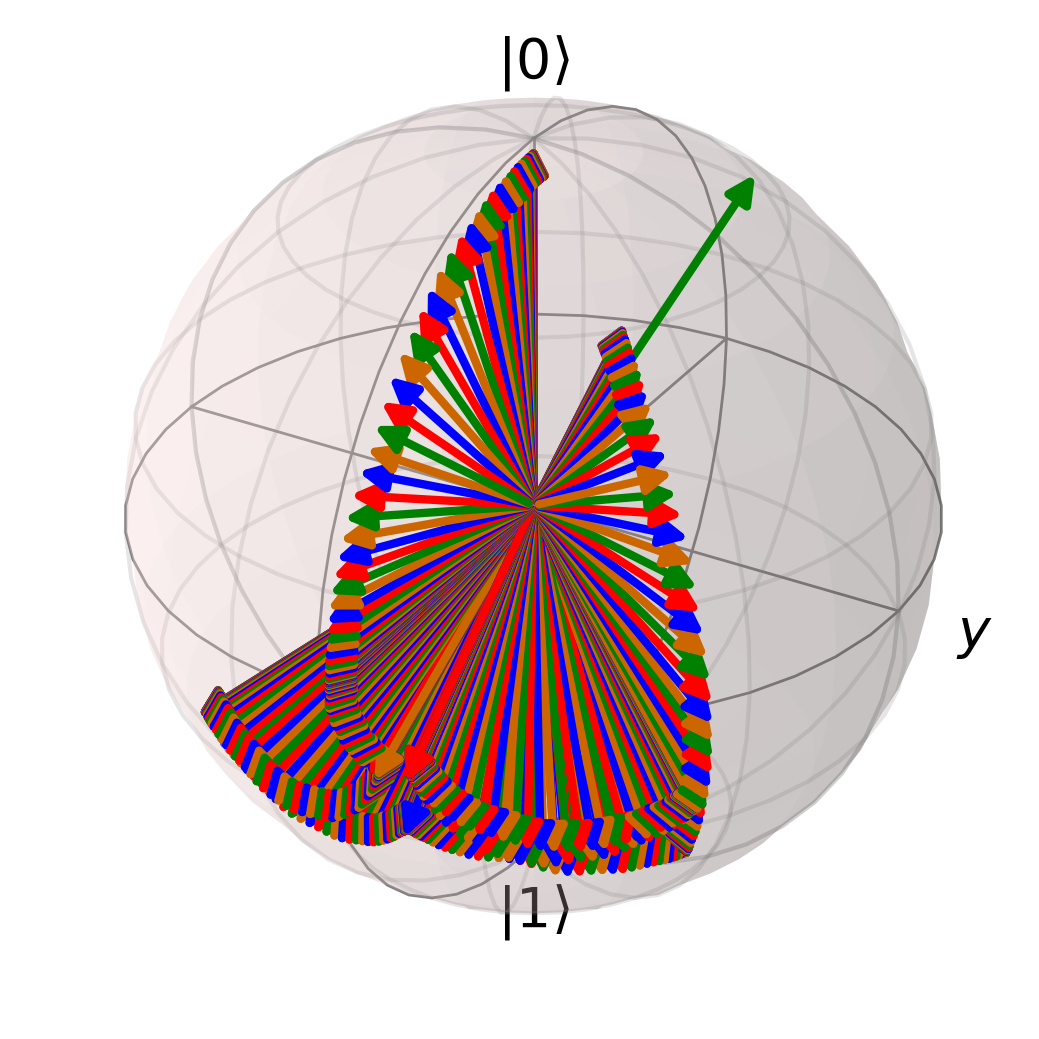

In [6]:
# test a circuit using simulate_circuit

%matplotlib qt
# setup transmon and gates
tr.ψ0 = (basis(tr.n_levels, 0) - 0*basis(tr.n_levels,1)).unit()
gate1 = "X90"
gate2 = "Z90"
gate3 = "Z180"
gate4 = "Y90"

# define the circuit
c = [U(gate_angles[gate1]), U(gate_angles[gate2]), U(gate_angles[gate3]), U(gate_angles[gate4])]
# c = [U(gate_angles["X90"])]

# simulate
res, f = simulate_circuit(tr, c, plot=True)